In [1]:
import numpy as np

import scipy as sp
from scipy.stats import multivariate_normal
from scipy.interpolate import interp1d

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import batman
import emcee
import corner

from datetime import datetime
startTime1=datetime.now()

${\LARGE{\textbf{----READ IN DATA FILES----}}}
\\ \hspace{1cm} \textrm{currently reads in from ermay_ext files generated with the MOPSS pipeline.}
\\ \hspace{1cm} \textrm{can easily be modified to read in any data array.}$

In [2]:
path='/Volumes/ermay_ext/Magellan/ut20160811/SaveData_Wasp52/'
data=np.load(path+'LCwhite.npz')['data']
yerr=np.load(path+'LCwhite.npz')['err_t']

time=np.load(path+'Obs_times.npz')['times']

import sys
sys.path.insert(0,path) 
from SystemCons import *

/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:2813: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)


<Container object of 3 artists>

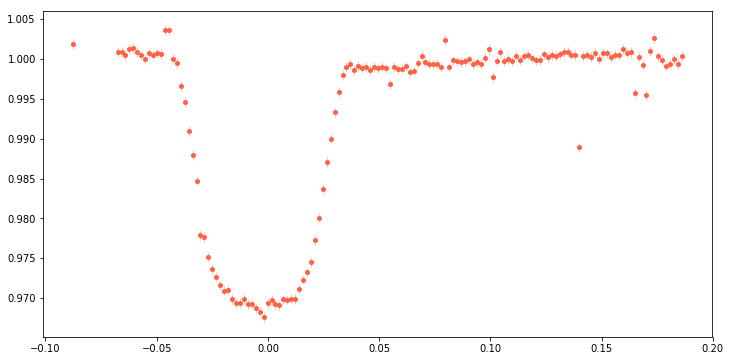

In [3]:
plt.figure(figsize=(12,6))

plt.plot(time,data,'.',markersize=8,color='tomato')
plt.errorbar(time,data,yerr=yerr*10,capsize=0,fmt=None,linewidth=0.5,color='tomato',alpha=0.8)

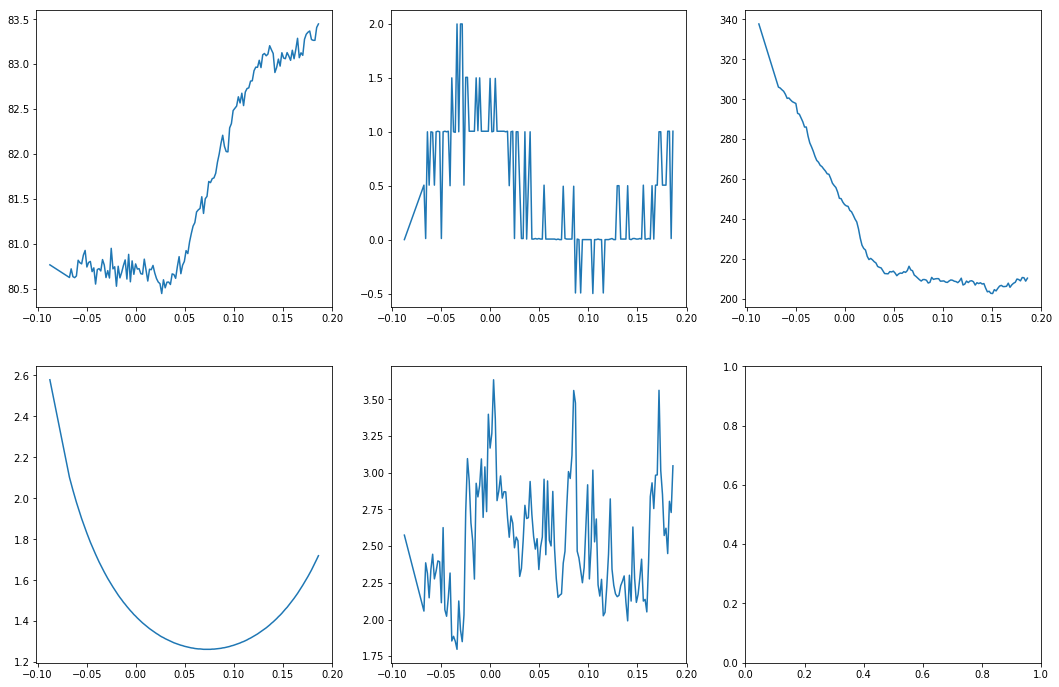

In [4]:
npar=np.load(path+'NoiseModel_Inputs_200.npz')

x_shift=npar['white_x']
y_shift=npar['yshift']
bg_cnts=npar['white_bg']

Z=(np.load(path+'HeaderData.npz')['airmass'])
fwhm=(np.load(path+'FlattenedSpectra.npz')['fwhm_ar'])[0,:]

NOISEP=np.vstack((x_shift,y_shift,bg_cnts,Z,fwhm))

fig,ax=plt.subplots(2,3,figsize=(18,12))

ax[0,0].plot(time,x_shift)
ax[0,1].plot(time,y_shift)
ax[0,2].plot(time,bg_cnts)
ax[1,0].plot(time,Z)
ax[1,1].plot(time,fwhm)
plt.show()

${\LARGE{\textbf{The MEAN: LC Model}}}$

In [6]:
def LC_model(t,t0,per,rp,inc,ecc,w,u0,u1):
    params=batman.TransitParams()
    params.t0=t0
    params.per=per
    params.rp=rp
    Ms_s=np.random.normal(loc=Ms,scale=Ms_e)
    Rs_s=np.random.normal(loc=Rs,scale=Rs_e)
    params.a=((((params.per*24.*60.*60.)**2.*Grav*Ms_s)/(4*np.pi**2.))**(1./3.))/Rs_s
    params.inc=inc
    params.ecc=ecc
    params.w=w
    params.u=(u0,u1)
    params.limb_dark='quadratic'

    model=batman.TransitModel(params,t)
    lc=model.light_curve(params)
    return lc

from george.modeling import Model

class Model(Model):
    parameter_names = ("t0", "per", "rp", "inc", "u0", "u1")

    def get_value(self, t):
        params=batman.TransitParams()
        params.t0=self.t0
        params.per=self.per
        params.rp=self.rp
        Ms_s=np.random.normal(loc=Ms,scale=Ms_e)
        Rs_s=np.random.normal(loc=Rs,scale=Rs_e)
        params.a=((((params.per*24.*60.*60.)**2.*Grav*Ms_s)/(4*np.pi**2.))**(1./3.))/Rs_s
        params.inc=self.inc
        params.ecc=ecc
        params.w=w
        params.u=(self.u0,self.u1)
        params.limb_dark='quadratic'

        model=batman.TransitModel(params,t)
        lc=model.light_curve(params)
        return lc

${\LARGE{\textbf{The Kernel: Gibson+ 2011}}}$

In [7]:
def GibsonKernel(xi,eta,sig,npm,npm2=None):
    
    # function defines the kernel with multiple inputs
    
    # K = number of inputs
    # A = number of exposures
    
    # n is the input matrix of parameters. should have dimensions [K,A]
    # xi is the maximum covariance hyperparameter
    # eta is an array of length K, the inverse scale parameters
    # sig is the white noise std deviation (sig^2 variance)
    
    K=npm.shape[0]
    A=npm.shape[1]
    
    COVa=np.empty([A,A])*np.nan
    
    if npm2 is None:
        for n in range(0,A):
            for m in range(0,A):
                summ=np.exp(-1.0*np.sum(eta*(npm[:,n]-npm[:,m])**2.))
                COVa[n,m]=xi*summ+1.0*sig**2.
    else:
        for n in range(0,A):
            for m in range(0,A):
                summ=np.exp(-1.0*np.sum(eta*(npm[:,n]-npm2[:,m])**2.))
                COVa[n,m]=xi*summ+1.0*sig**2.
    
    return np.copy(COVa)

############################################################
def expsqKernel(alpha,dx):
    amp,ell = alpha
    return amp*amp*np.exp(-dx**2./(2*ell*ell))

${\LARGE{\textbf{The Stats of it all: Priors and Likelihoods}}}$

In [88]:
############################################################
def log_gaus(mean,sig,param):
    return -np.log(np.sqrt(2*np.pi*sig**2.))-((param-mean)**2.)/(2*sig**2.)

def log_prior(p):
    t0_f,per_f,rp_f,inc_f,u0_f,u1_f=p
    if t0_f>-0.1 and t0_f<0.1 and rp_f>rpdn and rp_f<rpup and np.abs(u1_f-truth['u1'])<0.1 and np.abs((u1_f-truth['u1'])-(u0_f-truth['u0']))<0.05:
        return log_gaus(per,per_e,per_f)+log_gaus(inc,inc_e,inc_f)
    else:
        return -np.inf
    
############################################################
def log_like(r,K):
    try:
        val=-0.5 * (np.dot(r, np.linalg.solve(K, r)) + np.linalg.slogdet(K)[1])
    except np.linalg.LinAlgError as err:
        val=-np.inf
    return val

############################################################
def log_prob(p,prior_fn,like_fn,kernel_fn,mean_model,t,y,yerr):
    
    global prob_save
    global NOISEP
    
    #t0_f,per_f,rp_f,inc_f,u0_f,u1_f,eta0_f,eta1_f,eta2_f,eta3_f,eta4_f,xi_f,sig_f=p
    
    k = mean_model.vector_size  #number of params in mean model
    
    #Covariance Matrix#
#     eta_f = np.array([eta0_f,eta1_f,eta2_f,eta3_f,eta4_f])
#     COV_f = kernel_fn(xi_f,eta_f,sig_f,NOISEP)
#     COV_f[np.diag_indices_from(COV_f)] += yerr**2.
    COV_f=kernel_fn(p[k:],t[:, None] - t[None, :])
    COV_f[np.diag_indices_from(COV_f)] += yerr**2.
    
    #Calculate Mean Model, Residuals#
    mean_model.set_parameter_vector(p[:k])
    resid = y - mean_model.get_value(t)
    
    #Calculate Priors#
    lnprior=prior_fn(p[:k])
    if not np.isfinite(lnprior):
        prob_save=np.append(prob_save,-np.inf)
        return -np.inf
    
    #Calculate Likelihood#
    lnlike=like_fn(resid,COV_f)
    
    #Calculate Posterior#
    lnpost=lnprior+lnlike
    
    if not np.isfinite(lnpost):
        prob_save=np.append(prob_save,-np.inf)
        return -np.inf
    else:
        prob_save=np.append(prob_save,lnpost)
        return lnpost
    
############################################################
def log_prob_nosave(p,prior_fn,like_fn,kernel_fn,mean_model,t,y,yerr):
    
    #t0_f,per_f,rp_f,inc_f,u0_f,u1_f,eta0_f,eta1_f,eta2_f,eta3_f,eta4_f,xi_f,sig_f=p
    
    k = mean_model.vector_size  #number of params in mean model
    
    #Covariance Matrix#
#     eta_f = np.array([eta0_f,eta1_f,eta2_f,eta3_f,eta4_f])
#     COV_f = kernel_fn(xi_f,eta_f,sig_f,NOISEP)
#     COV_f[np.diag_indices_from(COV_f)] += yerr**2.
    COV_f=kernel_fn(p[k:],t[:, None] - t[None, :])
    COV_f[np.diag_indices_from(COV_f)] += yerr**2.
    
    #Calculate Mean Model, Residuals#
    mean_model.set_parameter_vector(p[:k])
    resid = y - mean_model.get_value(t)
    
    #Calculate Priors#
    lnprior=prior_fn(p[:k])
    if not np.isfinite(lnprior):
        #prob_save=np.append(prob_save,-np.inf)
        return -np.inf
    
    #Calculate Likelihood#
    lnlike=like_fn(resid,COV_f)
    
    #Calculate Posterior#
    lnpost=lnprior+lnlike
    
    if not np.isfinite(lnpost):
        #prob_save=np.append(prob_save,-np.inf)
        return -np.inf
    else:
        #prob_save=np.append(prob_save,lnpost)
        return lnpost

${\LARGE{\textbf{George: Set up GP}}}$

In [89]:
t=time#[1:-2]
y=data#[1:-2]
yerr=yerr#[1:-2]

wave=[3640,4450,5510,6580,8060,12200]#,16300,21900]                                                                                             
u0_func=interp1d(wave,q0)
u1_func=interp1d(wave,q1)
u0=u0_func(6000)
u1=u1_func(6000)

truth=dict(t0=t0,per=per,rp=rp,inc=inc,u0=u0,u1=u1)

kwargs=dict(**truth)
m_model=Model(**kwargs)

${\LARGE{\textbf{emcee: Set up MCMC}}}$

In [90]:
nwalkers=80
nburnin=50
nsteps=15000


start=np.array([t0,per,rp,inc,u0,u1])

eta0=0.
eta1=0.
eta2=0.
eta3=0.
eta4=0.
xi0=0.
sig0=0.

amp0=0.
ell0=0.

#g0=np.append(start,np.array([eta0,eta1,eta2,eta3,eta4,xi0,sig0]))
g0=np.append(start,np.array([amp0,ell0]))
ndim=len(g0)

t0_arr=np.linspace(t0-0.1,t0+0.1,10**6.)
per_arr=np.linspace(per-5*per_e,per+5*per_e,10**6.)
rp_arr=np.linspace(rpdn,rpup,10**6.)                                                                                              
inc_arr=np.linspace(inc-5*inc_e,inc+5*inc_e,10**6.)
u0_arr=np.linspace(u0-0.2,u0+0.2,10**6.)
u1_arr=np.linspace(u1-0.2,u1+0.2,10**6.) 

oinarr=np.linspace(-10,10,10**6.)

pos0=np.empty([nwalkers,ndim])
for i in range(nwalkers):
    pos0[i,:]=np.array([np.random.choice(t0_arr),np.random.choice(per_arr),np.random.choice(rp_arr),
                        np.random.choice(inc_arr),np.random.choice(u0_arr),np.random.choice(u1_arr),
                       np.random.choice(oinarr),np.random.choice(oinarr)])#,np.random.choice(oinarr),
                      # np.random.choice(oinarr),np.random.choice(oinarr),np.random.choice(oinarr),
                      #  np.random.choice(oinarr)])

/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an i

${\LARGE{\textbf{emcee: Running MCMC}}}$

In [92]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,log_prob,a=2.0,
                               args=(log_prior,log_like,expsqKernel,m_model,t,y,yerr))

print '     -->> Running Burn-in...'
time1=datetime.now()
p0,____,_____=sampler.run_mcmc(pos0,nburnin)
time2=datetime.now()
print '           Time to Run: ', time2-time1
sampler.reset()

prob_save=np.array([])

print '     -->> Running Chain...'
for i, result in enumerate(sampler.sample(p0,iterations=nsteps)):
    if (i+1)%(nsteps/10) ==0:
        print 100.*(float(i+1) / nsteps),'          ', datetime.now()
        
print '     -->> Mean Acceptance Fraction: ', np.mean(sampler.acceptance_fraction)

samples=sampler.chain[:,:,:].reshape((-1,pos0.shape[1]))

     -->> Running Burn-in...
           Time to Run:  0:00:05.738159
     -->> Running Chain...
10.0            2018-08-10 12:47:10.817611
20.0            2018-08-10 12:49:40.629966
30.0            2018-08-10 12:52:49.077082
40.0            2018-08-10 12:56:39.417296
50.0            2018-08-10 13:01:38.364644
60.0            2018-08-10 13:06:47.167429
70.0            2018-08-10 13:12:52.115816
80.0            2018-08-10 13:19:09.507697
90.0            2018-08-10 13:27:28.601278
100.0            2018-08-10 13:37:22.127188
     -->> Mean Acceptance Fraction:  0.029003333333333332


${\LARGE{\textbf{emcee: Results}}}$

In [94]:
print prob_save.shape
print samples.shape

(1200080,)
(1200000, 8)


In [95]:
extra=prob_save.shape[0]-samples.shape[0]
probs=prob_save[:samples.shape[0]]
print probs.shape

print np.nanmax(probs)
best_index=np.argmax(probs)
print best_index

best_params=samples[best_index-extra,:]
print best_params

(1200000,)
885.8284050435489
498396
[-3.45022004e-03  1.74488420e+00  1.71359862e-01  8.54210012e+01
  4.76959418e-01  7.06346612e-02 -1.49494725e-03 -9.17383096e-04]


In [96]:
# probs=np.empty([nwalkers*nsteps])*np.nan
# for p in range(0,nwalkers*nsteps):
#     if p%1000==0:
#         print p
#     probs[p]=log_prob_nosave(samples[p,:],log_prior,log_like,expsqKernel,m_model,t,y,yerr)

In [97]:
print np.nanmax(probs)
best_index=np.argmax(probs)
print best_index
print probs[best_index]

best_params=samples[best_index,:]
test=log_prob_nosave(best_params,log_prior,log_like,expsqKernel,m_model,t,y,yerr)

print test

885.8284050435489
498396
885.8284050435489
860.2242164150811


In [100]:
print best_params

[-3.45039743e-03  1.74489180e+00  1.71365301e-01  8.54209917e+01
  4.76855430e-01  7.05700699e-02 -1.49940832e-03 -9.18397145e-04]


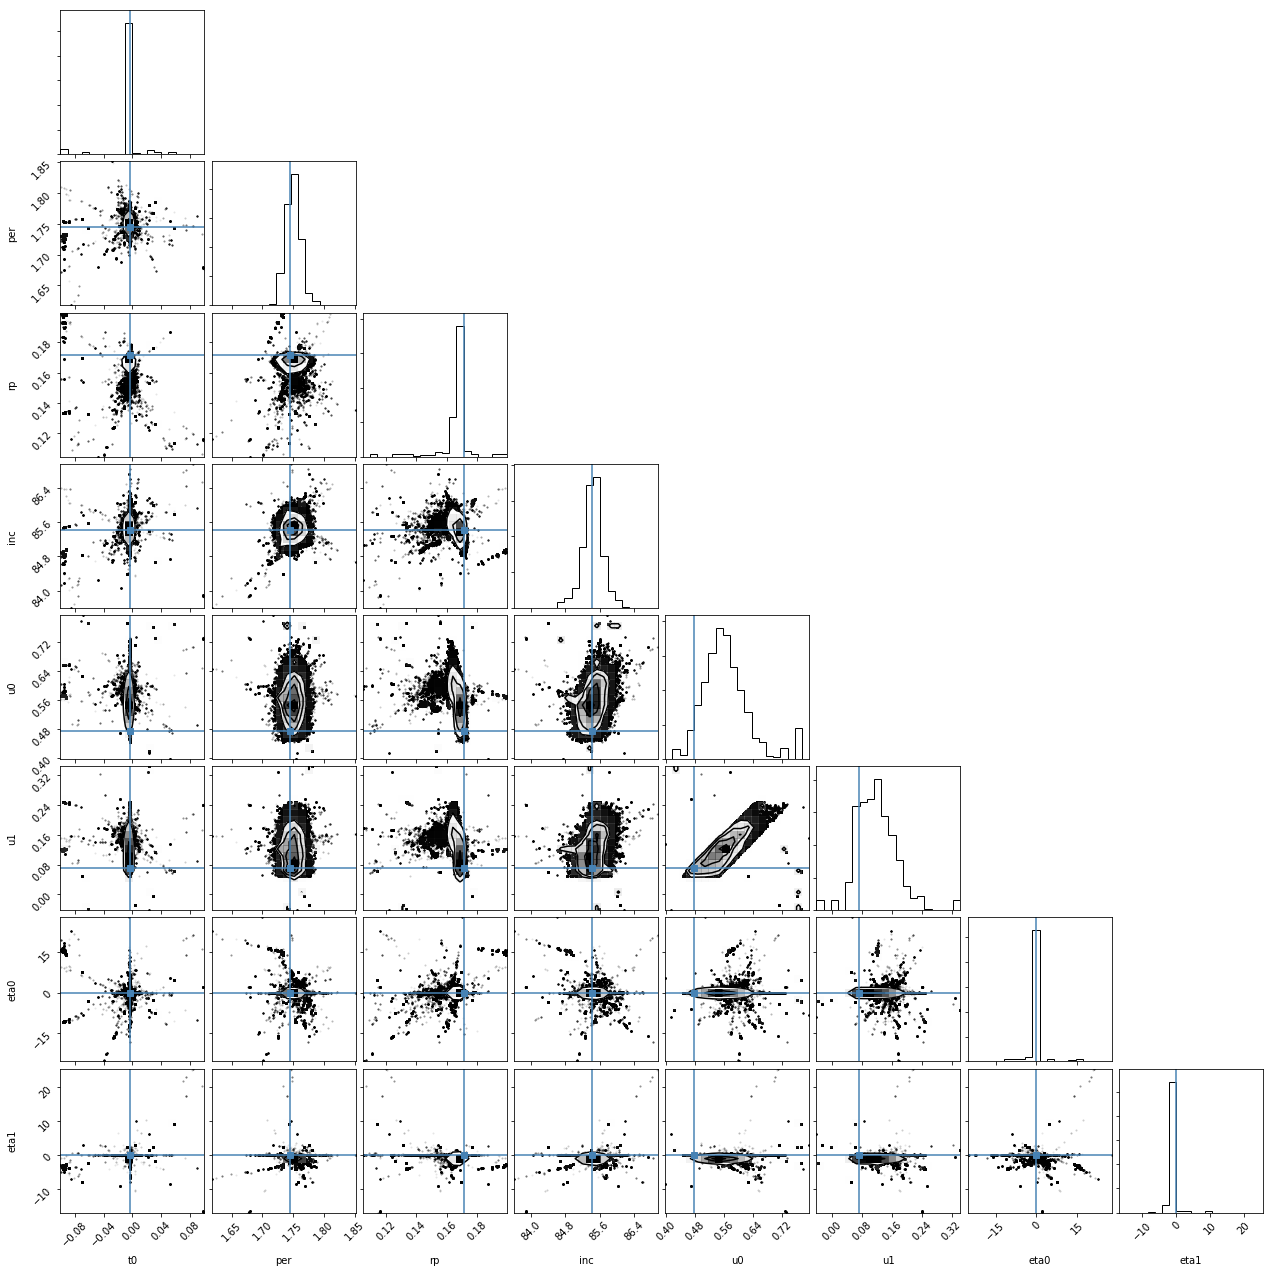

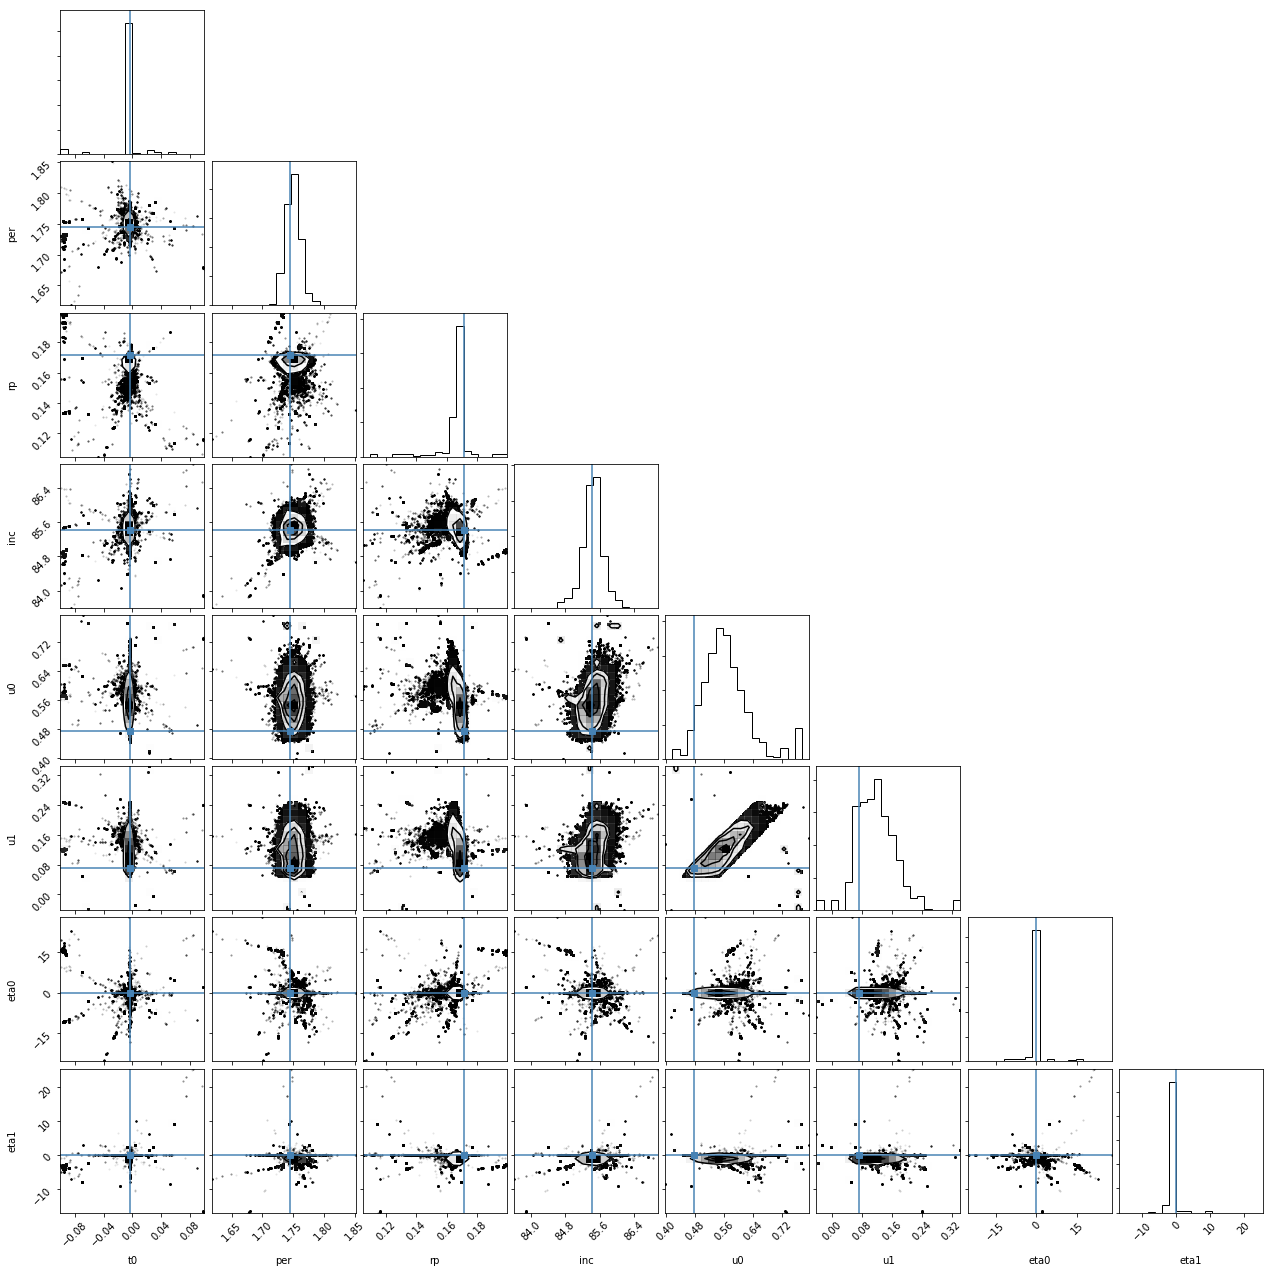

In [102]:
labels=['t0','per','rp','inc','u0','u1','eta0','eta1','eta2','eta3','eta4','xi','sig']

corner.corner(samples,labels=labels,truths=best_params)#,show_titles=True)

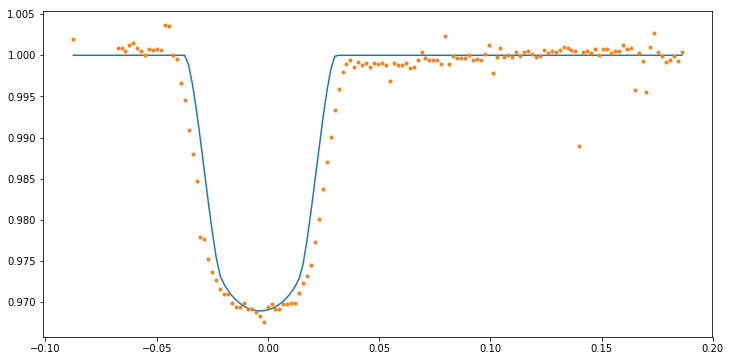

In [98]:
k = m_model.vector_size  #number of params in mean model
    
m_model.set_parameter_vector(best_params[:k])
resid = y - m_model.get_value(t)
best_model=m_model.get_value(t)


plt.figure(figsize=(12,6))
plt.plot(t,best_model)
plt.plot(t,y,'.')

In [ ]:
np.savez_compressed('QUICKSAVE_GP_SHORTRUN1.npz',samples=samples, prob_save=prob_save,best_params=best_params,best_model=best_model)


In [20]:
#np.savez_compressed('QUICKSAVE_GP_LONGRUN1.npz',samples=samples, prob_save=prob_save,best_params=best_params,best_model=best_model)

1.7497798
